## Sarcasm Detection - CNN with extra Fields

# Installation & Download

In [1]:
import warnings
%load_ext autoreload
%autoreload 2

In [2]:
try:
    from google.colab import drive

    IN_COLAB = True
except:
    IN_COLAB = False

In [3]:
if IN_COLAB:
    !pip install datasets
    !pip install transformers
    !pip install wandb

In [4]:
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import tqdm
import torch
import random
from sklearn import model_selection, feature_extraction
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from datasets import load_dataset, concatenate_datasets, load_metric, Dataset
from transformers import pipeline, AutoModel, BertTokenizer, BertModel, AutoConfig, AutoTokenizer, DataCollatorWithPadding
import os
from torch.nn.functional import pad
from typing import List
from torch.utils.data import TensorDataset, DataLoader, Dataset as Ds

In [5]:
if IN_COLAB:
    from google.colab import drive

    drive.mount('/content/drive')

In [6]:
# Source https://nlp.cs.princeton.edu/SARC/
!wget -nc 'https://nlp.cs.princeton.edu/SARC/0.0/key.csv'
!wget -nc 'https://nlp.cs.princeton.edu/SARC/0.0/main/test-balanced.csv.bz2'
!wget -nc 'https://nlp.cs.princeton.edu/SARC/0.0/main/train-balanced.csv.bz2'
!bzip2 -dk 'test-balanced.csv.bz2'
!bzip2 -dk 'train-balanced.csv.bz2'

File ‘key.csv’ already there; not retrieving.

File ‘test-balanced.csv.bz2’ already there; not retrieving.

File ‘train-balanced.csv.bz2’ already there; not retrieving.

bzip2: Output file test-balanced.csv already exists.
bzip2: Output file train-balanced.csv already exists.


# Load Data Set
Citation: https://medium.com/@therpsvishal/sarcasm-detection-on-reddit-data-4b399df855ad

In [7]:
# Get Train Data
header_names = pd.read_csv('key.csv', sep='\t').columns.values.tolist()
train = pd.read_csv('train-balanced.csv', sep='\t', names=header_names)
test = pd.read_csv('test-balanced.csv', sep='\t', names=header_names)

# Pre-processing

comments have lengths min:1.0, mean: 56.692298864334525, median: 46.0, max: 10000.0
parent_comments have lengths min:1, mean: 133.35310923937453, median: 75.0, max: 40301

Dropping 0.1% from min and max extremes we have:
comments have lengths min:1.0, mean: 56.05465451131691, median: 46.0, max: 363.0
parent_comments have lengths min:2.0, mean: 129.45715033182344, median: 75.0, max: 2579.0


Text(0.5, 1.0, 'Parent Comments')

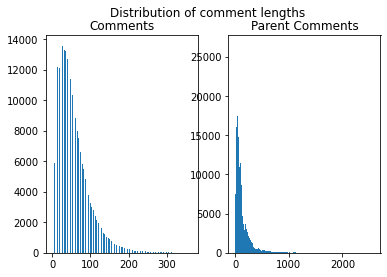

In [8]:
comment_lengths = train['comment'].str.len()
parent_lengths = train['parent_comment'].str.len()
print(
    f'comments have lengths min:{comment_lengths.min()}, mean: {comment_lengths.mean()}, median: {comment_lengths.median()}, max: {comment_lengths.max()}')
print(
    f'parent_comments have lengths min:{parent_lengths.min()}, mean: {parent_lengths.mean()}, median: {parent_lengths.median()}, max: {parent_lengths.max()}')


def drop_outliers(series, pct):
    sorted_series = series.sort_values()
    lower_pct, upper_pct = pct, 1 - pct
    lower_idx, upper_idx = int(lower_pct * series.size), int(upper_pct * series.size)
    lower_bound, upper_bound = sorted_series.tolist()[lower_idx], sorted_series.tolist()[upper_idx]
    return series.where(lambda x: (lower_bound <= x) & (x <= upper_bound)).dropna()


print('\nDropping 0.1% from min and max extremes we have:')
t_comment_lengths = drop_outliers(comment_lengths, 0.001)
print(
    f'comments have lengths min:{t_comment_lengths.min()}, mean: {t_comment_lengths.mean()}, median: {t_comment_lengths.median()}, max: {t_comment_lengths.max()}')

t_parent_lengths = drop_outliers(parent_lengths, 0.001)
print(
    f'parent_comments have lengths min:{t_parent_lengths.min()}, mean: {t_parent_lengths.mean()}, median: {t_parent_lengths.median()}, max: {t_parent_lengths.max()}')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Distribution of comment lengths')
ax1.hist(t_comment_lengths.tolist(), bins=1000)
ax1.set_title('Comments')
ax2.hist(t_parent_lengths.tolist(), bins=1000)
ax2.set_title('Parent Comments')

genuine score mean 6.097644773101247
genuine score median 2.0


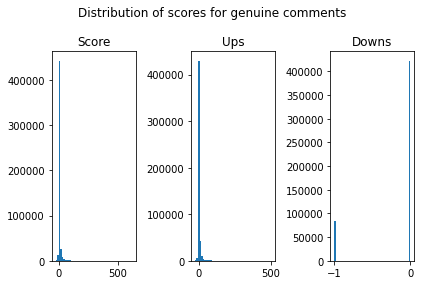

In [46]:
genuine, sarcastic = train[train['label'] == 0], train[train['label'] == 1]
genuine_score, genuine_ups, genuine_downs = genuine['score'], genuine['ups'], genuine['downs']

# trim 0.1% from both ends
t_genuine_score = drop_outliers(genuine_score, 0.001)
t_genuine_ups = drop_outliers(genuine_ups, 0.001)
t_genuine_downs = drop_outliers(genuine_downs, 0.001)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Distribution of scores for genuine comments')
ax1.hist(t_genuine_score.tolist(), bins=50)
ax1.set_title('Score')
ax2.hist(t_genuine_ups.tolist(), bins=50)
ax2.set_title('Ups')
ax3.hist(t_genuine_downs.tolist(), bins=50)
ax3.set_title('Downs')

print(f'genuine score mean {t_genuine_score.mean()}')
print(f'genuine score median {t_genuine_score.median()}')
fig.tight_layout()

sarcastic score mean 5.642374285838894
sarcastic score median 2.0


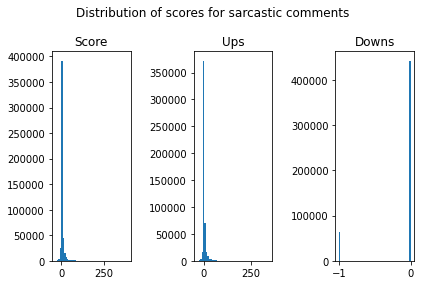

In [45]:
sarcastic_score, sarcastic_ups, sarcastic_downs = sarcastic['score'], sarcastic['ups'], sarcastic['downs']

# trim 0.1% from both ends
t_sarcastic_score = drop_outliers(sarcastic_score, 0.001)
t_sarcastic_ups = drop_outliers(sarcastic_ups, 0.001)
t_sarcastic_downs = drop_outliers(sarcastic_downs, 0.001)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Distribution of scores for sarcastic comments')
ax1.hist(t_sarcastic_score.tolist(), bins=50)
ax1.set_title('Score')
ax2.hist(t_sarcastic_ups.tolist(), bins=50)
ax2.set_title('Ups')
ax3.hist(t_sarcastic_downs.tolist(), bins=50)
ax3.set_title('Downs')

print(f'sarcastic score mean {t_sarcastic_score.mean()}')
print(f'sarcastic score median {t_sarcastic_score.median()}')
fig.tight_layout()

In [11]:
label_by_sub = train.groupby(['subreddit', 'label'], as_index=False).size()
only_sarcastic_subs = label_by_sub[label_by_sub['label'] == 1]
subs = train.groupby(['subreddit'], as_index=False).size()


def get_sarcasm_rate(row):
    name = row['subreddit']
    sarcastic_entry = only_sarcastic_subs[only_sarcastic_subs['subreddit'] == name]
    if sarcastic_entry.size > 0:
        return sarcastic_entry.iloc[0]['size'] / row['size']
    else:
        return 0


sarcasm_rates_by_subreddit = subs.apply(get_sarcasm_rate, axis=1)
#only_sarcastic[only_sarcastic['subreddit'] == 'a'].size

Text(0.5, 1.0, 'Rates of Sarcasm by Subreddit')

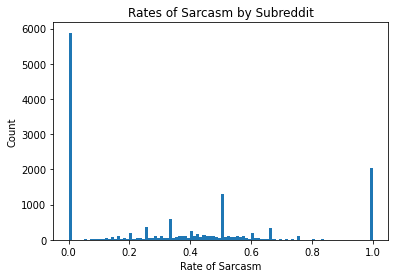

In [12]:
plt.hist(sarcasm_rates_by_subreddit.tolist(), bins=100)
plt.xlabel('Rate of Sarcasm')
plt.ylabel('Count')
plt.title('Rates of Sarcasm by Subreddit')

In [13]:
label_by_author = train.groupby(['author', 'label'], as_index=False).size()
only_sarcastic_authors = label_by_author[label_by_author['label'] == 1]
authors = train.groupby(['author'], as_index=False).size()


def get_sarcasm_rate(row):
    name = row['author']
    sarcastic_entry = only_sarcastic_authors[only_sarcastic_authors['author'] == name]
    if sarcastic_entry.size > 0:
        return sarcastic_entry.iloc[0]['size'] / row['size']
    else:
        return 0

# Expensive to compute so only run when necessary.
# sarcasm_rates_by_author = authors.apply(get_sarcasm_rate, axis=1)

In [14]:
# plt.hist(sarcasm_rates_by_author.tolist(), bins=100)
# plt.xlabel('Rate of Sarcasm')
# plt.ylabel('Count')
# plt.title('Rates of Sarcasm by Author')

## Convolutional Neural Network (CNN)

In [15]:
# CNN Code Here
dirs = ['cnn', 'cnn/cache', 'cnn/runs', 'cnn/models']
_, cache_dir, run_dir, model_dir = dirs
seed = 777
max_length = 512
batch_size = 10
data_percentage = 0.01  # Value in the range (0,1] to determine how much data to use for training.
model_names = ['bert-base-uncased']
model_output_size = 768  # depends on the embedding length generated by the encoder
print(model_names)
run_id = ''
project_name = 'cs263-nlp-final'

if IN_COLAB:
    from requests import get

    filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
    notebook_name = filename.split('.')[0]
    save_path = f'/content/drive/MyDrive/Colab Notebooks/{notebook_name}-outputs'

else:
    save_path = '.'

print(f'Saving experiment results to {save_path}')

dirs = [save_path, f'{save_path}/cnn', f'{save_path}/cnn/cache', f'{save_path}/cnn/runs', f'{save_path}/cnn/models']
_, _, cache_dir, run_dir, model_dir = dirs

for d in dirs:
    if not os.path.exists(d):
        os.mkdir(d)

['bert-base-uncased']
Saving experiment results to .


In [26]:
from cnn_generator import create_cnn_model
from typing import Tuple
import torch.nn as nn


# Neural Net Definitions
class BasicMLP(nn.Module):
    def __init__(self, input_shape: (int, int)):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape[0] * input_shape[1], 2),
        )

    def forward(self, xb):
        return self.network(xb)


small_cnn_conf = {
    'modules': [{
        'type': 'conv',
        'filter_count': 16,
        'filter_size': (8, 8),
        'pad': 0,
        'stride': 4
    },
        {'type': 'pool',
         'pool_size': (4, 4),
         'pool_func': 'max',
         'pad': 0,
         'stride': 1
         },
        {
            'type': 'conv',
            'filter_count': 8,
            'filter_size': (4, 4),
            'pad': 0,
            'stride': 2
        }],
    'fc_layers': [256],
    'batch_norm': False,
    'dropout': 0,

}


class SmallCNN(nn.Module):
    def __init__(self, input_shape: (int, int)):
        super().__init__()
        #self.body = AutoModel.from_pretrained(model_name,config=AutoConfig.from_pretrained(model_name, output_attentions=True,output_hidden_states=True))
        self.input_shape = input_shape
        self.network = create_cnn_model(small_cnn_conf, (1,input_shape[0],input_shape[1]), classes=2)

    def forward(self, xb):
        # Need to add channel dimension for CNN
        batch, height, width = xb.shape
        return self.network(xb.view(batch,1,height,width))


In [17]:
import torch.optim as optim


class SarcasmDataset(Ds):
    def __init__(self, data: List[Tuple[str, int]]):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def create_model():
    # model = SmallCNN(
    #     (max_length, model_output_size))
    model = MultiCNN()
    model.to('cuda:0')
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001)
    # Uncomment for debugging or analysis purposes
    print(model)
    print(f'Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')
    return model, loss_fn, optimizer

In [40]:
class MultiCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, (8, 8), stride=4)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d((4, 4), stride=1)
        self.conv2 = nn.Conv2d(16, 8, (4, 4), stride=2)
        self.relu2 = nn.ReLU()
        # Conv output + injected author and subreddit
        self.dense1 = nn.Linear(45384 + 10*model_output_size*2, 256)
        self.relu3 = nn.ReLU()
        self.output = nn.Linear(256, 2)

    def forward(self, x, extra_x):
        batch, height, width = x.shape
        # Need to add channel dimension for CNN
        x_reshaped = x.view(batch, 1, height, width)
        out = self.relu1(self.conv1(x_reshaped))
        out = self.pool1(out)
        out = self.relu2(self.conv2(out))
        out = torch.concat((torch.flatten(out, start_dim=1),torch.flatten(extra_x, start_dim=1)),dim=1)
        out = self.relu3(self.dense1(out))
        out = self.output(out)

        return out

def train_one_epoch(epoch_index,
                    tb_writer,
                    training_loader,
                    model,
                    loss_fn,
                    optimizer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in tqdm.tqdm(enumerate(training_loader), total=len(training_loader)):
        # Every data instance is an input + label pair
        (comment_pairs, authors, subreddits), labels = data

        # Zero your gradients for every bach
        optimizer.zero_grad()
        s = len(comment_pairs)
        # Make predictions for this batch
        embeddings = pipe(list(comment_pairs) + list(authors) + list(subreddits))
        c_embeddings, a_embeddings, s_embeddings = embeddings[:s], embeddings[s:2 * s], embeddings[2 * s:]
        tensor_y = labels.to('cuda:0')
        tensors_x = [torch.tensor(co, device='cuda:0') for co in c_embeddings]

        to_tensor = lambda l: torch.squeeze(torch.tensor(l, device='cuda:0'))
        to_padded = lambda t: pad(t, (0, 0, 0, 10 - t.shape[0])) if t.shape[0] < 10 else t[:10,:]
        tensors_xtra = [(to_tensor(au), to_tensor(su)) for au,su in zip(a_embeddings,s_embeddings)]
        padded_xtra = torch.stack([torch.concat((to_padded(au),to_padded(su))) for au, su in tensors_xtra], 0)
        padded_x = torch.squeeze(torch.stack([pad(t, (0, 0, 0, max_length - t.shape[1])) for t in tensors_x], 1), 0)
        outputs = model(padded_x,padded_xtra)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, tensor_y)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 200 == 0:
            last_loss = running_loss / 200  # loss per batch
            #print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss


In [41]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import time
import warnings

# We're not really using the pipeline optimally and it keeps complaining about that.
warnings.simplefilter("ignore")
EPOCHS = 10


def train_model(training_loader,
                validation_loader,
                model,
                loss_fn,
                optimizer,
                fold):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    writer = SummaryWriter(f'{run_dir}/cnn_trainer_{timestamp}')
    early_stopping_limit = 2  # how many epochs of decreased validation accuracy to tolerate until training is stopped early.

    best_vloss = 1_000_000.
    best_accuracy = 0
    best_precision = 0
    best_recall = 0
    best_f1 = 0

    for epoch in range(EPOCHS):
        print(f'EPOCH {fold + 1}-{epoch + 1}')

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(epoch, writer, training_loader, model, loss_fn, optimizer)

        # We don't need gradients on to do reporting
        model.train(False)

        running_vloss = 0.0
        running_accuracy = 0.0
        running_precision = 0.0
        running_recall = 0.0
        running_f1 = 0.0

        with torch.no_grad():
            for i, vdata in tqdm.tqdm(enumerate(validation_loader), total=len(validation_loader)):
                (comment_pairs, authors, subreddits), labels = vdata
                s = len(comment_pairs)
                # Make predictions for this batch
                embeddings = pipe(list(comment_pairs) + list(authors) + list(subreddits))
                c_embeddings, a_embeddings, s_embeddings = embeddings[:s], embeddings[s:2 * s], embeddings[2 * s:]
                tensor_y = labels.to('cuda:0')

                tensors_x = [torch.tensor(co, device='cuda:0') for co in c_embeddings]
                to_tensor = lambda l: torch.squeeze(torch.tensor(l, device='cuda:0'))

                to_padded = lambda t: pad(t, (0, 0, 0, 10 - t.shape[0])) if t.shape[0] < 10 else t[:10,:]
                tensors_xtra = [(to_tensor(au), to_tensor(su)) for au,su in zip(a_embeddings,s_embeddings)]
                padded_xtra = torch.stack([torch.concat((to_padded(au),to_padded(su))) for au, su in tensors_xtra], 0)
                padded_x = torch.squeeze(torch.stack([pad(t, (0, 0, 0, max_length - t.shape[1])) for t in tensors_x], 1), 0)
                voutputs = model(padded_x,padded_xtra)

                _, vpredictions = torch.max(voutputs, dim=1)
                vloss = loss_fn(voutputs, tensor_y)
                vpredictions = vpredictions.cpu()
                tensor_y = tensor_y.cpu()
                vaccuracy = accuracy_score(tensor_y, vpredictions)
                vprecision = precision_score(tensor_y, vpredictions, zero_division=0)
                vrecall = recall_score(tensor_y, vpredictions, zero_division=0)
                vf1 = f1_score(tensor_y, vpredictions, zero_division=0)

                running_vloss += vloss
                running_accuracy += vaccuracy
                running_precision += vprecision
                running_recall += vrecall
                running_f1 += vf1

        avg_vloss = running_vloss / (i + 1)
        avg_accuracy = running_accuracy / (i + 1)
        avg_precision = running_precision / (i + 1)
        avg_recall = running_recall / (i + 1)
        avg_f1 = running_f1 / (i + 1)

        print(
            f'LOSS train {round(avg_loss, 3)} valid {round(avg_vloss.item(), 3)} valid accuracy {round(avg_accuracy, 3)}')

        # Log the running loss averaged per batch
        # for both training and validation
        writer.add_scalars('Training vs. Validation Loss',
                           {'Training': avg_loss,
                            'Validation': avg_vloss, },
                           epoch + 1)
        writer.add_scalars('Metrics',
                           {'Accuracy': avg_accuracy,
                            'Precision': avg_precision,
                            'Recall': avg_recall,
                            'F1 Score': avg_f1, },
                           epoch + 1)
        writer.flush()

        # Track best performance, and save the model's state
        if avg_accuracy > best_accuracy:
            best_vloss = avg_vloss
            best_accuracy = avg_accuracy
            best_precision = avg_precision
            best_recall = avg_recall
            best_f1 = avg_f1

            model_path = f'{model_dir}/{model.__class__.__name__}_{timestamp}_{epoch}'
            torch.save(model.state_dict(), model_path)
        elif early_stopping_limit > 0:
            early_stopping_limit -= 1
        else:
            print('Training stopped due to no improvement in accuracy.')
            return best_accuracy, best_precision, best_recall, best_f1

    return best_accuracy, best_precision, best_recall, best_f1

In [42]:
start = time.time()

r_mean = lambda v: round(np.mean(v), 3)
r_min = lambda v: round(np.min(v), 3)
r_max = lambda v: round(np.max(v), 3)
r_med = lambda v: round(np.median(v), 3)


def k_fold_cross_validation(k=5, stop_after=None):
    final_accuracies = []
    final_precisions = []
    final_recalls = []
    final_f1s = []
    splits_indices = [int(i / k * len(trainable_set)) for i in range(1, k + 1)]
    splits_indices = [0] + splits_indices
    folds_to_evaluate = k if stop_after is None else stop_after

    for i in range(k):
        print(f'\n\nFOLD {i + 1}')
        first, last = splits_indices[i], splits_indices[i + 1]
        training_fold = (trainable_set['comment_pair'][:first] + trainable_set['comment_pair'][last:],
                         trainable_set['author'][:first] + trainable_set['author'][last:],
                         trainable_set['subreddit'][:first] + trainable_set['subreddit'][last:],
                         trainable_set['label'][:first] + trainable_set['label'][last:])
        validation_fold = (trainable_set['comment_pair'][first:last],
                           trainable_set['author'][first:last],
                           trainable_set['subreddit'][first:last],
                           trainable_set['label'][first:last])
        #print(f'Training fold indices: [{0},{first}) and [{last},{splits_indices[-1]}]')
        #print(f'Validation fold indices: [{first},{last})')
        training_data = [((comment_pair, author, subreddit), label) for comment_pair, author, subreddit, label in
                         zip(training_fold[0], training_fold[1], training_fold[2], training_fold[3])]
        validation_data = [((comment_pair, author, subreddit), label) for comment_pair, author, subreddit, label in
                           zip(validation_fold[0], validation_fold[1], validation_fold[2], validation_fold[3])]
        training_loader = DataLoader(SarcasmDataset(training_data), shuffle=True, batch_size=batch_size)
        validation_loader = DataLoader(SarcasmDataset(validation_data), shuffle=False, batch_size=batch_size)

        model, loss_function, optimizer = create_model()

        a, p, r, f = train_model(training_loader, validation_loader, model, loss_function, optimizer, i)
        print('Training run metrics:')
        print(f'accuracy: {round(a, 3)}, precision: {round(p, 3)}, recall: {round(r, 3)}, F1: {round(f, 3)}')
        final_accuracies.append(a)
        final_precisions.append(p)
        final_recalls.append(r)
        final_f1s.append(f)

        if i + 1 >= folds_to_evaluate:
            break

    print(f'---------------------------------------------------------------------------------------------------------')
    print(f'Average across all {k} runs:')
    print(
        f'accuracy: {r_mean(final_accuracies)}, precision: {r_mean(final_precisions)}, recall: {r_mean(final_recalls)}, F1: {r_mean(final_f1s)}')
    print(f'\nMin across all {k} runs:')
    print(
        f'accuracy: {r_min(final_accuracies)}, precision: {r_min(final_precisions)}, recall: {r_min(final_recalls)}, F1: {r_min(final_f1s)}')
    print(f'\nMax across all {k} runs:')
    print(
        f'accuracy: {r_max(final_accuracies)}, precision: {r_max(final_precisions)}, recall: {r_max(final_recalls)}, F1: {r_max(final_f1s)}')
    print(f'\nMedian across all {k} runs:')
    print(
        f'accuracy: {r_med(final_accuracies)}, precision: {r_med(final_precisions)}, recall: {r_med(final_recalls)}, F1: {r_med(final_f1s)}')


for model_name in model_names:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    dataset = Dataset.from_pandas(train)
    subset = dataset.train_test_split(test_size=data_percentage, seed=seed)['test']
    combined = [f'{p_c}{tokenizer.sep_token}{c}' for p_c, c in
                tqdm.tqdm(zip(subset['parent_comment'], subset['comment']))]
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    trainable_set = subset.add_column('comment_pair', combined)
    #print(trainable_set[0])

    embedder = AutoModel.from_pretrained(model_name)
    pipe = pipeline('feature-extraction', model=embedder, tokenizer=tokenizer, max_length=512, truncation=True,
                    padding='max_length', device=0)
    feature = pipe(trainable_set['comment_pair'][0])
    k_fold_cross_validation(k=5, stop_after=3)
end = time.time()
print(f'took {round(end - start, 2)}s')

10109it [00:00, 428887.22it/s]


Flattening the indices:   0%|          | 0/11 [00:00<?, ?ba/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




FOLD 1
MultiCNN(
  (conv1): Conv2d(1, 16, kernel_size=(8, 8), stride=(4, 4))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=(4, 4), stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 8, kernel_size=(4, 4), stride=(2, 2))
  (relu2): ReLU()
  (dense1): Linear(in_features=60744, out_features=256, bias=True)
  (relu3): ReLU()
  (output): Linear(in_features=256, out_features=2, bias=True)
)
Trainable Parameters: 15554330
EPOCH 1-1


100%|██████████| 203/203 [01:15<00:00,  2.67it/s]


LOSS train 0 valid 0.694 valid accuracy 0.498
EPOCH 1-2


  4%|▍         | 8/203 [00:02<01:11,  2.73it/s]


KeyboardInterrupt: 